# Feature Engineering and Selection

* Filter out listings that are not full-time Airbnbs
* Create ```yearly_revenue``` for each listing by combining availability calendars for each month
* Merge ```yearly_revenue``` with listing features
* Examine data that has been filtered and merged
* Clean data
* Create and simplify new features (```distance_dt```, ```property_type```, etc...)

In the EDA notebook, we discovered that some features such as location and accommodates were closely related to a listing's nightly price. But before we can look at what features to include in the model, we will need to create our response variable, yearly revenue.

Our data does not contain such data, but what we can use are the multiple data sets scraped each month and use that to estimate a listing's yearly reveneue. \
In the calandars data set we see each listing's availability for each day of the year. If the availability is Flase, that means that the listing was booked for the day, or the host made it unavailable to be booked. This could be because it was a seasonal listing or hosts just wanted to try out Airbnb for a short period of time. To combat this, we will look at listings used solely for Airbnb by excluding listings that were not listed every month.

Using this method we get a more pure data set that ensures we most accurately estimate a listing's yearly revenue

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


from collections import Counter

from src.data import download_data
from src.features import distance

# Download data

Data ranges from Oct 2020 to July 2021

In [2]:
# Download all calendar data sets.
calendar_links = [
                  'http://data.insideairbnb.com/united-states/wa/seattle/2020-10-25/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2020-11-12/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2020-12-23/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2021-01-23/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2021-02-21/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2021-03-18/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2021-04-23/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2021-06-30/data/calendar.csv.gz',
                  'http://data.insideairbnb.com/united-states/wa/seattle/2021-07-14/data/calendar.csv.gz'
]

data_frames = {}
for link in calendar_links:
    date = re.search(r'\d{4}-\d{2}-\d{2}', link)[0]
    fp = os.path.join('..', 'data', 'raw', f'{date}_calendar.csv.gz')
    download_data(fp, link)
    df = pd.read_csv(fp, parse_dates=['date'])
    data_frames[date] = df

In [3]:
# Combine all listings data scraped each month.
df_columns = next(iter(data_frames.values())).columns
combined_df = pd.DataFrame(columns=df_columns)

for df in data_frames.values():
    df_copy = df.copy()
    combined_df = pd.concat([combined_df, df_copy]).drop_duplicates(['listing_id', 'date'], keep='last')

In [4]:
# number of unique listings from Oct to July
combined_df.listing_id.nunique()

7166

# Creating yearly revenue

* Filter out listing that are not full-time
* Sum up all prices between Oct 2020 and Oct 2021 that were booked



Out of 7166 listings that have appeared since October 2020, only 2123 listings have been active every month.

In [5]:
# Count listings each month.
ids = []
for df in data_frames.values():
    ids.extend(df.listing_id.unique())
    
# Sanity check: number of unique listings from Oct to July.
len([k for k, v in Counter(ids).items() if v >= 1])

7166

In [6]:
# How many listings in combined that were active for all months?
greater_months = {k: v for k, v in Counter(ids).items() if v >= 9}
len(set(greater_months).intersection(set(combined_df.listing_id.unique())))

2123

In [7]:
combined_df.index = combined_df.listing_id
full_time = combined_df.loc[greater_months].copy().reset_index(drop=True)
full_time.sample(5, random_state=123)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
228351,6687395,2020-11-22,t,$99.00,$99.00,2,1125
274588,8207987,2022-02-08,t,$98.00,$98.00,30.0,1125.0
467824,15221864,2022-03-17,f,$104.00,$104.00,1.0,1125.0
457605,14902010,2021-09-16,f,$91.00,$91.00,1.0,1125.0
67769,254340,2020-11-15,f,$85.00,$85.00,30,180


In [8]:
# Convert available to boolean and price to float
full_time['available'] = full_time.available == 't'
full_time['price'] = full_time.price.replace('[\$,]', '', regex=True).astype(float)

# Create booked column
full_time['booked'] = np.logical_xor(full_time.available, 1).astype(int)

In [9]:
sub = full_time[full_time.date <= '2021-10-24']
booked = sub[sub.available == False].groupby('listing_id').sum()

In [10]:
booked['occupancy_rate'] = booked.booked / 365
booked['avg_revenue_nightly'] = booked.price / 365
booked['avg_revenue_monthly'] = booked.price / 12

booked = booked.rename(columns={"price": "yearly_revenue"})
booked['avg_booked_price'] = sub[sub.available == False].groupby('listing_id').mean().price

In [11]:
booked.describe()

,available,yearly_revenue,booked,occupancy_rate,avg_revenue_nightly,avg_revenue_monthly,avg_booked_price
count,2091.0,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,0.0,31352.309421,221.981827,0.608169,85.896738,2612.692452,144.420204
std,0.0,26285.321597,90.378342,0.247612,72.014580,2190.443466,107.448888
min,0.0,159.000000,1.000000,0.002740,0.435616,13.250000,24.585366
25%,0.0,16292.000000,163.000000,0.446575,44.635616,1357.666667,85.000000
50%,0.0,26171.000000,235.000000,0.643836,71.701370,2180.916667,117.000000
75%,0.0,38750.000000,294.000000,0.805479,106.164384,3229.166667,163.986879
max,0.0,435830.000000,365.000000,1.000000,1194.054795,36319.166667,1454.454545


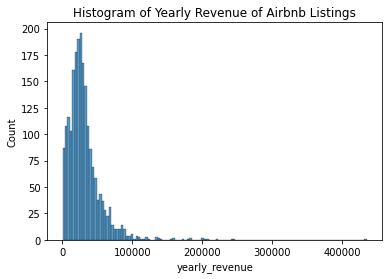

In [12]:
# Histogram of Yearly Revenue of Airbnb Listings
sns.histplot(x='yearly_revenue', data=booked).set(title='Histogram of Yearly Revenue of Airbnb Listings')
plt.show()

# Merge yearly revenue with listings data

Listings data contains attributes of the actually listing. We will combine this with our estamate for yearly revenue.

In [13]:
url = 'http://data.insideairbnb.com/united-states/wa/seattle/2020-10-25/data/listings.csv.gz'
date = re.search(r'\d{4}-\d{2}-\d{2}', url)[0]
fp = os.path.join('..', 'data', 'raw', f'{date}listings.csv.gz')
download_data(fp, url)

In [14]:
listings = pd.read_csv(fp)
listings = listings.rename(columns={"id": "listing_id"})

merged = pd.merge(listings, booked.reset_index(), on='listing_id', how='right')
merged.shape

(2091, 81)

In [15]:
# In our effor to make a yearly revenue estimator, we want attributes that any host or aspiring host can input
cols = [
    'neighbourhood_group_cleansed', 'latitude', 'longitude',
    'property_type', 'room_type', 'accommodates',
    'bathrooms_text', 'bedrooms', 'beds', 'avg_booked_price', 'occupancy_rate',
    'yearly_revenue'
]

merged[cols]

,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,avg_booked_price,occupancy_rate,yearly_revenue
0,Other neighborhoods,47.55017,-122.31937,Private room in apartment,Private room,2,3 shared baths,1.0,2.0,63.217021,0.643836,14856.0
1,West Seattle,47.55539,-122.38474,Entire house,Entire home/apt,4,1 bath,2.0,3.0,168.164983,0.813699,49945.0
2,West Seattle,47.55624,-122.38598,Entire guest suite,Entire home/apt,3,1 bath,2.0,2.0,128.041825,0.720548,33675.0
3,West Seattle,47.56612,-122.37273,Entire house,Entire home/apt,4,1 bath,2.0,2.0,84.962121,0.723288,22430.0
4,Delridge,47.55365,-122.36326,Private room in house,Private room,1,2 shared baths,1.0,1.0,70.569507,0.610959,15737.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2086,Northgate,47.71848,-122.32857,Private room in bungalow,Private room,2,1 shared bath,1.0,1.0,64.609756,0.112329,2649.0
2087,Northgate,47.72012,-122.32740,Private room in bungalow,Private room,2,1 private bath,1.0,1.0,90.000000,0.087671,2880.0
2088,Northgate,47.71834,-122.32710,Private room in bungalow,Private room,2,1 shared bath,1.0,1.0,64.576923,0.142466,3358.0
2089,Northgate,47.71965,-122.32734,Private room in house,Private room,2,1 private bath,1.0,1.0,88.408284,0.463014,14941.0


# EDA

* Average yearly revenue is 32,352 while median is 26,171
* Average averaged booked price is 144.42, while median is 117.00
* Median listing accommodates 4 people, has 1 bedroom and 2 beds or less.=
* 75% of listings have 2 bedrooms and 2 beds or less
* 75% of listings make 38,750 or less in yearly revenue
* Most common listing is an entire apartment in downtown
* Shared room is the least common listing
* All features except coordinates are highly correlated (> 0.5) with each other and ```yearly_revenue```

In [16]:
merged[cols].describe()

,latitude,longitude,accommodates,bedrooms,beds,avg_booked_price,occupancy_rate,yearly_revenue
count,2091.000000,2091.000000,2091.000000,1796.000000,2090.000000,2091.000000,2091.000000,2091.000000
mean,47.628209,-122.335188,3.763749,1.585189,1.914354,144.420204,0.608169,31352.309421
std,0.049291,0.034168,2.278387,0.928642,1.390605,107.448888,0.247612,26285.321597
min,47.496210,-122.418740,1.000000,1.000000,0.000000,24.585366,0.002740,159.000000
25%,47.604285,-122.359090,2.000000,1.000000,1.000000,85.000000,0.446575,16292.000000
50%,47.625680,-122.333140,4.000000,1.000000,2.000000,117.000000,0.643836,26171.000000
75%,47.665605,-122.312280,4.000000,2.000000,2.000000,163.986879,0.805479,38750.000000
max,47.733530,-122.245540,16.000000,7.000000,19.000000,1454.454545,1.000000,435830.000000


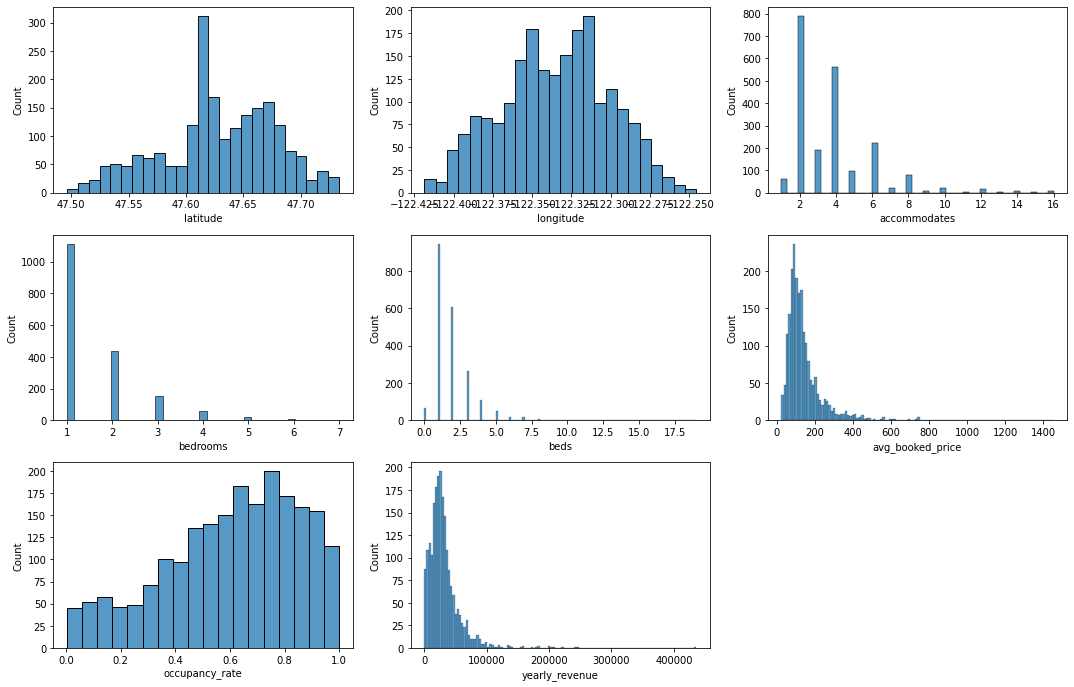

In [17]:
# histograms
num_cols = merged[cols].describe().columns
fig = plt.figure(figsize=(15, 25))
for index, col in enumerate(merged[num_cols]):
    plt.subplot(8, 3, index+1)
    sns.histplot(x = col, data=merged)
fig.tight_layout(pad=1.0)

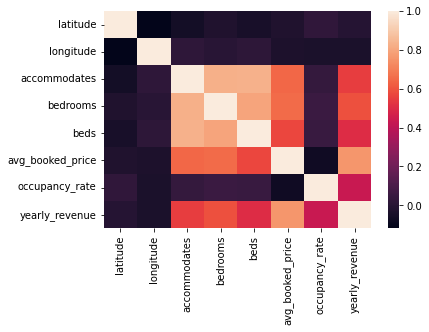

In [18]:
# Correlation
sns.heatmap(merged[num_cols].corr())
plt.show()

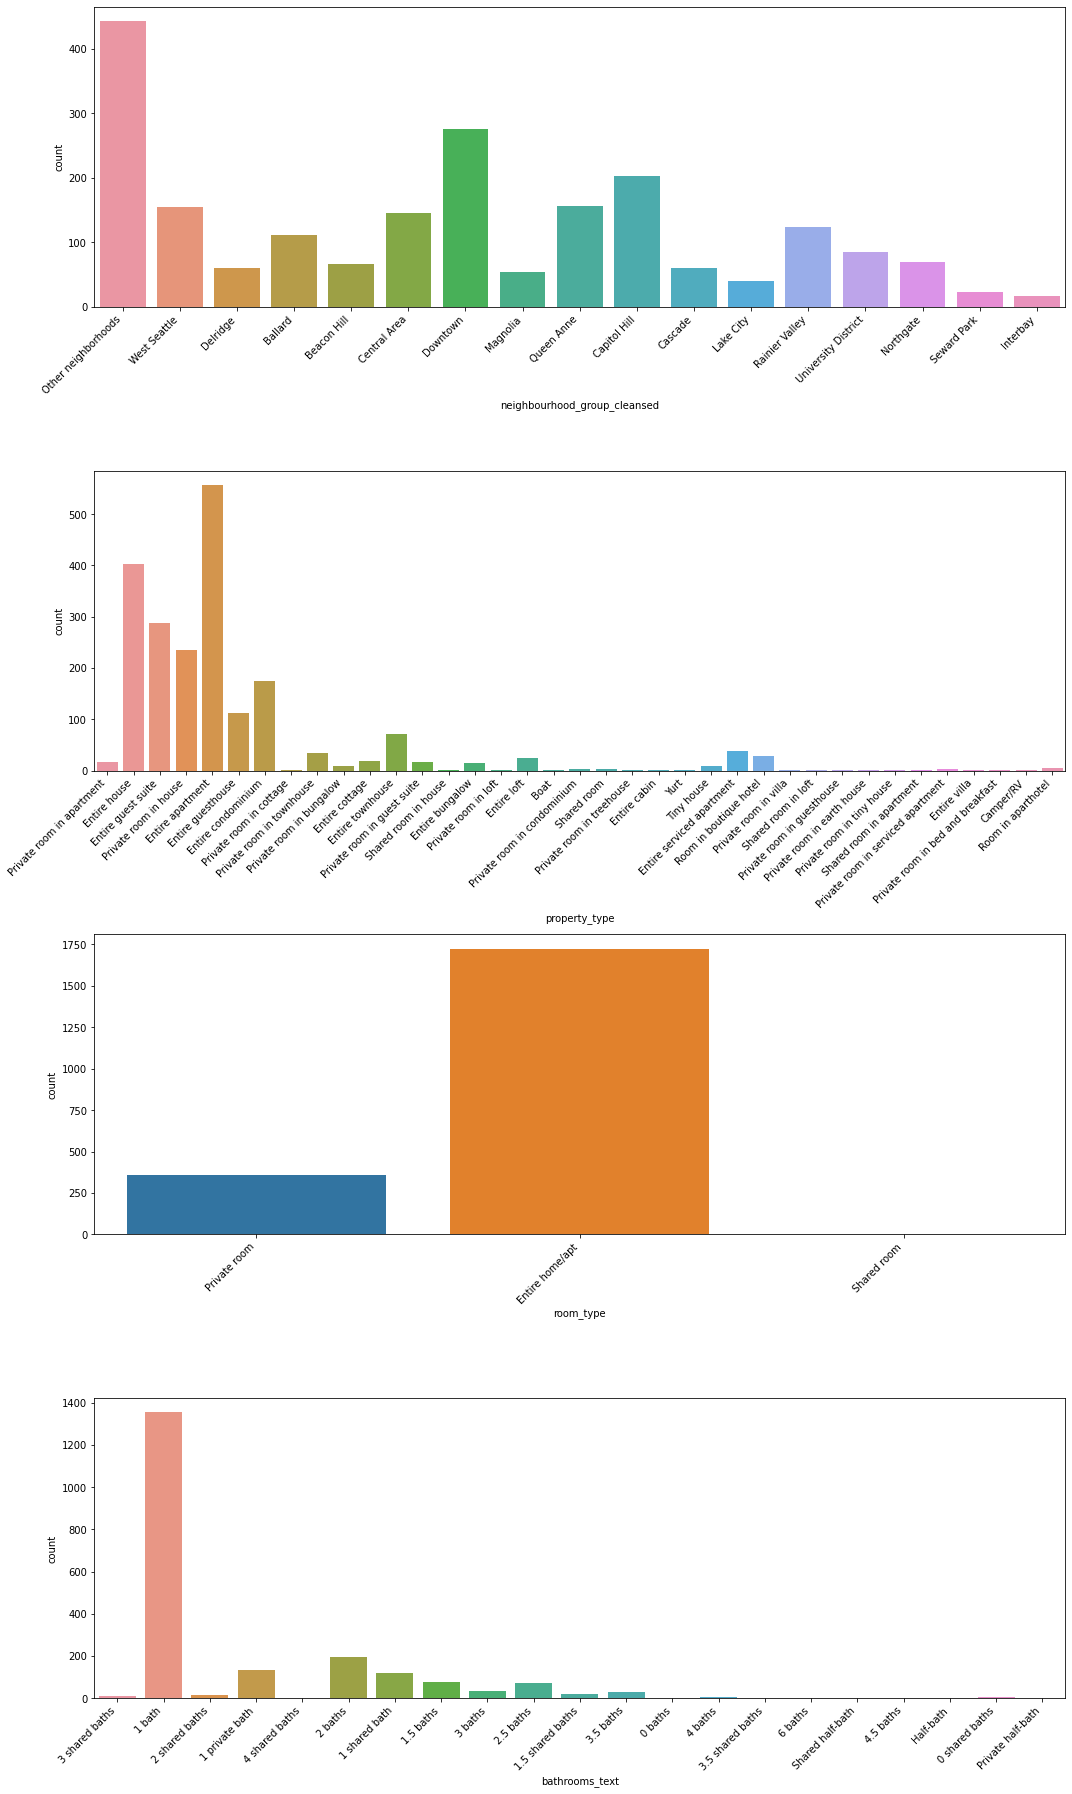

In [21]:
# countplots
fig = plt.figure(figsize=(15, 25))
for index, col in enumerate(merged[cols].drop(num_cols, axis=1)):
    plt.subplot(4, 1, index+1)
    count = sns.countplot(x=merged.loc[:, col])
    count.set_xticklabels(count.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.tight_layout(pad=1.0)

# Data cleaning / Fill missing values

Checking for missing values, we found that bathrooms_text, bedrooms, and beds have missing values.
* ```bathrooms_text``` filled with 1 - listings actually had bathroms
* ```bedrooms``` filled wth 0 - listings were actually studios
* ```beds``` filled with 1 - listings had beds

In [22]:
merged[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2090
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  2091 non-null   object 
 1   latitude                      2091 non-null   float64
 2   longitude                     2091 non-null   float64
 3   property_type                 2091 non-null   object 
 4   room_type                     2091 non-null   object 
 5   accommodates                  2091 non-null   int64  
 6   bathrooms_text                2089 non-null   object 
 7   bedrooms                      1796 non-null   float64
 8   beds                          2090 non-null   float64
 9   avg_booked_price              2091 non-null   float64
 10  occupancy_rate                2091 non-null   float64
 11  yearly_revenue                2091 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 276.9+ KB


## Bedrooms

Looking at the listings for bedrooms that are null, we notice that they indeed do not have a bedroom and are studios. Accordingly, we fill these values with 0.

In [23]:
display(merged[merged.bedrooms.isnull()])

# Fill.
merged.bedrooms.fillna(0.0, inplace=True)

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,available,yearly_revenue,booked,occupancy_rate,avg_revenue_nightly,avg_revenue_monthly,avg_booked_price
56,635878,https://www.airbnb.com/rooms/635878,20201025051148,2020-10-25,Center UW Spacious 2 Beds (203),It has a Walk Score of 98 out of 100. This loc...,It is located in the bustling and vibrant Univ...,https://a0.muscache.com/pictures/79114056/ea9e...,3074414,https://www.airbnb.com/users/show/3074414,...,3,0,0.32,0,7177.0,80,0.219178,19.663014,598.083333,89.712500
68,723846,https://www.airbnb.com/rooms/723846,20201025051148,2020-10-25,"The Cozy Cottage in Maple Leaf (UW, Green Lake)",Our beautiful little cottage was built in 2012...,People who live in the Maple Leaf neighborhood...,https://a0.muscache.com/pictures/08bf6c89-cf3c...,3737272,https://www.airbnb.com/users/show/3737272,...,0,0,1.43,0,18628.0,190,0.520548,51.035616,1552.333333,98.042105
119,1599010,https://www.airbnb.com/rooms/1599010,20201025051148,2020-10-25,Center UW Large Wood Floor King bed walk UW (104),Spacious and <br />Clean! super short walk to ...,It is located in the bustling and vibrant Univ...,https://a0.muscache.com/pictures/2935f0af-5c02...,3074414,https://www.airbnb.com/users/show/3074414,...,3,0,0.18,0,22703.0,293,0.802740,62.200000,1891.916667,77.484642
122,1647216,https://www.airbnb.com/rooms/1647216,20201025051148,2020-10-25,"Center UW New, Fancy & Cute, 04",This remodeled apt has Walk Score of 98 out of...,It is located in the bustling and vibrant Univ...,https://a0.muscache.com/pictures/60224437/476c...,3074414,https://www.airbnb.com/users/show/3074414,...,3,0,0.29,0,13718.0,182,0.498630,37.583562,1143.166667,75.373626
135,1820794,https://www.airbnb.com/rooms/1820794,20201025051148,2020-10-25,Cozy Guest Suite with Covered Backyard Patio,Sit out on the covered patio with direct views...,Queen Anne is one of the best places in Seattl...,https://a0.muscache.com/pictures/af2ac3cb-15d7...,9533123,https://www.airbnb.com/users/show/9533123,...,0,0,4.92,0,37470.0,306,0.838356,102.657534,3122.500000,122.450980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,45837480,https://www.airbnb.com/rooms/45837480,20201025051148,2020-10-25,"Lux Pioneer Square Studio w/ Gym, W/D, nr. Occ...",Feel at home wherever you choose to live with ...,This furnished apartment is located in Pioneer...,https://a0.muscache.com/pictures/c770d386-e2f0...,107434423,https://www.airbnb.com/users/show/107434423,...,0,0,NaN,0,14533.0,132,0.361644,39.816438,1211.083333,110.098485
2076,45870397,https://www.airbnb.com/rooms/45870397,20201025051148,2020-10-25,"Cozy Downtown Studio w/ Gym, W/D, walkable loc...",Show up and start living from day one in Seatt...,NaN,https://a0.muscache.com/pictures/519d9ca9-6f16...,107434423,https://www.airbnb.com/users/show/107434423,...,0,0,NaN,0,26817.0,171,0.468493,73.471233,2234.750000,156.824561
2080,45904038,https://www.airbnb.com/rooms/45904038,20201025051148,2020-10-25,"Ideal Pioneer Square 1BR w/ Gym, W/D, nr. Occi...",Feel at home wherever you choose to live with ...,This furnished apartment is located in Pioneer...,https://a0.muscache.com/pictures/f80bae92-0029...,107434423,https://www.airbnb.com/users/show/107434423,...,0,0,NaN,0,29342.0,245,0.671233,80.389041,2445.166667,119.763265
2082,45937532,https://www.airbnb.com/rooms/45937532,20201025051148,2020-10-25,Cozy suite with easy Downtown access!,Enjoy Seattle through our cozy and comfortable...,NaN,https://a0.muscache.com/pictures/04661f04-231d...,229095817,https://www.airbnb.com/users/show/229095817,...,0,0,NaN,0,40463.0,113,0.309589,110.857534,3371.916667,358.079646


## Beds

Luckly, only 1 item is missing for beds. We went in and looked at the listing and found that the listing offered a single bed.

In [24]:
display(merged[merged.beds.isnull()])

# Fill.
merged.beds.fillna(1.0, inplace=True)

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,available,yearly_revenue,booked,occupancy_rate,avg_revenue_nightly,avg_revenue_monthly,avg_booked_price
1903,42646755,https://www.airbnb.com/rooms/42646755,20201025051148,2020-10-25,Modern Private Hideaway in Brand New Ballard Home,"Be close to it all in this modern, cozy getawa...",The Dane is located kiddy-corner and offers co...,https://a0.muscache.com/pictures/85be9cdb-3cf4...,339761193,https://www.airbnb.com/users/show/339761193,...,1,0,1.31,0,23364.0,187,0.512329,64.010959,1947.0,124.941176


## Bathrooms

We also looked at the listing online and found that these listings have 1 bathroom

In [25]:
display(merged[merged.bathrooms_text.isnull()])

# Fill.
merged.bathrooms_text.fillna('1 bath', inplace=True)

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,available,yearly_revenue,booked,occupancy_rate,avg_revenue_nightly,avg_revenue_monthly,avg_booked_price
112,1520501,https://www.airbnb.com/rooms/1520501,20201025051148,2020-10-25,Io House (bunk 2L) - SLU walkable,<b>The space</b><br />About Io House:<br />Thi...,NaN,https://a0.muscache.com/pictures/23881273/b024...,1243056,https://www.airbnb.com/users/show/1243056,...,0,1,0.09,0,23835.0,365,1.000000,65.301370,1986.25,65.301370
1941,43320830,https://www.airbnb.com/rooms/43320830,20201025051148,2020-10-25,A-Seattle Urban Village- Guemes-Roof top view ...,"New, clean, modern, your own private room with...","With Amazon.com headquarters nearby, this neig...",https://a0.muscache.com/pictures/1ca03b43-2e83...,39834464,https://www.airbnb.com/users/show/39834464,...,30,0,NaN,0,7437.0,157,0.430137,20.375342,619.75,47.369427


In [26]:
# Check for any more missing values.
merged[cols].isnull().any()

neighbourhood_group_cleansed    False
latitude                        False
longitude                       False
property_type                   False
room_type                       False
accommodates                    False
bathrooms_text                  False
bedrooms                        False
beds                            False
avg_booked_price                False
occupancy_rate                  False
yearly_revenue                  False
dtype: bool

# Feature engineering

* Turn ```bathrooms_text``` to float
* Create distance from downtown feature: ```distance_dt``` (miles)
* Simplify ```property_type```

## Turn ```bathrooms_text``` to float

```bathrooms_text``` is text column that indicates the number as well as the type of bathroom. We will convert this into a float and turn any shared/half bath into the value 0.5.

In [27]:
merged['bathrooms_text']

0       3 shared baths
1               1 bath
2               1 bath
3               1 bath
4       2 shared baths
             ...      
2086     1 shared bath
2087    1 private bath
2088     1 shared bath
2089    1 private bath
2090     1 shared bath
Name: bathrooms_text, Length: 2091, dtype: object

In [28]:
# fix bathrooms
merged['bathrooms_text'] = merged['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 'Private half-bath'],'0.5 baths')
merged['bathrooms_text'] = [''.join(re.findall('\d*\.?\d+', item)) for item in merged['bathrooms_text']]
merged['bathrooms_text'] = merged['bathrooms_text'].astype(float)

## Distance from downtown

As seen in the EDA notebook, downtown commands the highest nightly prices. Because of this, we will create a new feature where we calculate the distance in miles from each listing to downtown Seattle.

In [29]:
# Calculate distace from downtown Seattle from coordinates.
downtown_coord = (47.614668, -122.344921)
merged['distance_dt'] = distance(downtown_coord[0], downtown_coord[1], merged.latitude, merged.longitude)

In [30]:
cols.append('distance_dt')
merged[cols].head()

,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,avg_booked_price,occupancy_rate,yearly_revenue,distance_dt
0,Other neighborhoods,47.55017,-122.31937,Private room in apartment,Private room,2,3.0,1.0,2.0,63.217021,0.643836,14856.0,4.613025
1,West Seattle,47.55539,-122.38474,Entire house,Entire home/apt,4,1.0,2.0,3.0,168.164983,0.813699,49945.0,4.496771
2,West Seattle,47.55624,-122.38598,Entire guest suite,Entire home/apt,3,1.0,2.0,2.0,128.041825,0.720548,33675.0,4.467778
3,West Seattle,47.56612,-122.37273,Entire house,Entire home/apt,4,1.0,2.0,2.0,84.962121,0.723288,22430.0,3.596171
4,Delridge,47.55365,-122.36326,Private room in house,Private room,1,2.0,1.0,1.0,70.569507,0.610959,15737.0,4.301960


## Simplify ```property_type```

```property_type``` has 37 unique types where as ```room_type``` gives us only 3. \
```property_type``` contains much more granular data than ```room_type```, but since there are lots of types, we risk over fitting. To solve this, we will simplify ```property_type``` to reduce the number of types by broadening and moving listings to certain types.

Looking at the countplot of types, we decide to simplify the types into Entire apartment, Entire house, Entire guest suite, Private room in house, Entire condomonium, Entire guesthouse, Entire townhouse, Other. Listings will be mapped into these 8 categories.

*Clarification condos are usually owned while apartments are usually rented. Hosts can rent apartments and then rent those same apartments out on Airbnb

In [31]:
print('Unique property types:', merged.property_type.nunique())
merged.groupby('property_type').count()['listing_id'].sort_values(ascending=False)

Unique property types: 37


property_type
Entire apartment                      557
Entire house                          403
Entire guest suite                    288
Private room in house                 236
Entire condominium                    174
Entire guesthouse                     112
Entire townhouse                       71
Entire serviced apartment              39
Private room in townhouse              35
Room in boutique hotel                 28
Entire loft                            24
Entire cottage                         19
Private room in guest suite            17
Private room in apartment              17
Entire bungalow                        15
Private room in bungalow               10
Tiny house                             10
Room in aparthotel                      5
Private room in condominium             4
Private room in serviced apartment      4
Shared room                             3
Private room in guesthouse              2
Entire cabin                            2
Private room in loft

In [32]:
merged['property_type_cleansed'] = merged['property_type']
merged['property_type_cleansed'] = merged['property_type_cleansed'].replace(['Entire serviced apartment', 'Entire loft'], 'Entire apartment')
merged['property_type_cleansed'] = merged['property_type_cleansed'].replace(['Entire cottage', 'Entire bungalow', 'Tiny house', 'Entire cabin', 'Entire villa'], 'Entire house')
merged['property_type_cleansed'] = merged['property_type_cleansed'].replace(['Room in boutique hotel', 'Private room in bed and breakfast'], 'Entire guest suite')
merged['property_type_cleansed'] = merged['property_type_cleansed'].replace(['Private room in townhouse', 'Private room in bungalow'], 'Private room in house')
merged['property_type_cleansed'] = merged['property_type_cleansed'].replace(['Private room in guest suite', 'Private room in apartment', 'Room in aparthotel', 'Private room in condominium', 'Private room in serviced apartment', 'Private room in guesthouse', 'Private room in loft', 'Private room in cottage', 'Private room in villa', 'Shared room', 'Shared room in loft', 'Shared room in house', 'Shared room in apartment', 'Boat', 'Private room in treehouse', 'Private room in tiny house', 'Private room in earth house', 'Camper/RV', 'Yurt'], 'Other')

In [33]:
print('Unique property types:', merged.property_type.nunique())
merged.groupby('property_type').count()['listing_id'].sort_values(ascending=False)

Unique property types: 37


property_type
Entire apartment                      557
Entire house                          403
Entire guest suite                    288
Private room in house                 236
Entire condominium                    174
Entire guesthouse                     112
Entire townhouse                       71
Entire serviced apartment              39
Private room in townhouse              35
Room in boutique hotel                 28
Entire loft                            24
Entire cottage                         19
Private room in guest suite            17
Private room in apartment              17
Entire bungalow                        15
Private room in bungalow               10
Tiny house                             10
Room in aparthotel                      5
Private room in condominium             4
Private room in serviced apartment      4
Shared room                             3
Private room in guesthouse              2
Entire cabin                            2
Private room in loft

In [34]:
cols.append('property_type_cleansed')
merged[cols].head()

,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,avg_booked_price,occupancy_rate,yearly_revenue,distance_dt,property_type_cleansed
0,Other neighborhoods,47.55017,-122.31937,Private room in apartment,Private room,2,3.0,1.0,2.0,63.217021,0.643836,14856.0,4.613025,Other
1,West Seattle,47.55539,-122.38474,Entire house,Entire home/apt,4,1.0,2.0,3.0,168.164983,0.813699,49945.0,4.496771,Entire house
2,West Seattle,47.55624,-122.38598,Entire guest suite,Entire home/apt,3,1.0,2.0,2.0,128.041825,0.720548,33675.0,4.467778,Entire guest suite
3,West Seattle,47.56612,-122.37273,Entire house,Entire home/apt,4,1.0,2.0,2.0,84.962121,0.723288,22430.0,3.596171,Entire house
4,Delridge,47.55365,-122.36326,Private room in house,Private room,1,2.0,1.0,1.0,70.569507,0.610959,15737.0,4.301960,Private room in house


# Export data

In [36]:
fp = os.path.join('..', 'data', 'interim', 'yearly_revenue.pkl')
pd.to_pickle(merged[cols], fp)